In [4]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader

from sklearn.metrics import roc_auc_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
df_features = pd.read_csv('Data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("Data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("Data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

In [6]:
# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

# creating classified and unclassified dataframes

classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# storing classified unclassified nodes seperatly for training and testing purpose
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]
del df_features, df_classes

In [7]:
# all nodes in data
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

In [19]:
#map_id

In [7]:
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

In [22]:
edges

,txId1,txId2
0,138670,4142
1,141325,142201
2,139232,139223
3,138150,140289
4,141268,141368
...,...,...
234350,100863,100525
234351,112040,112041
234352,100420,100419
234353,54833,81951


In [7]:
edge_index = np.array(edges.values).T

In [23]:
edge_index

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [24]:
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
# initializing random weights
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

torch.Size([2, 234355])


In [8]:
# maping txIds to corresponding indexes, to pass node features to the model
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)
classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index
# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0) 

In [9]:
labels = node_features['class'].values
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.double), dtype=torch.double)

# converting data to PyGeometric graph data format
data_train = Data(x=node_features, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double)) 

In [10]:
y_train = labels[classified_idx]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, train_idx, valid_idx = train_test_split(node_features[classified_idx], y_train, classified_idx, test_size=0.15, random_state=42, stratify=y_train)

In [11]:
data_train.y[classified_idx].sum()

tensor(4545., dtype=torch.float64)

In [13]:
import gc
gc.collect()

132

In [14]:
#Creating the NN
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(165, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(64, 64)
        self.conv4 = GCNConv(128, 1) 

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv4(x, edge_index)

        return F.sigmoid(x)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model.double()
data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

In [29]:
model.train()

cum_loss = []
cum_auc = []

for epoch in range(70):
    optimizer.zero_grad()
    out = model(data_train)
    out = out.reshape((data_train.x.shape[0]))
    loss = criterion(out[train_idx], data_train.y[train_idx])
    auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) 
    loss.backward()
    optimizer.step()
    
    cum_loss.append(loss)
    cum_auc.append(auc)
    
    if epoch%5 == 0:
      print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))

epoch: 0 - loss: 0.2806950015047342 - roc: 0.8821384432724033
epoch: 5 - loss: 0.24914204535005088 - roc: 0.9024000044994993
epoch: 10 - loss: 0.22147972764113047 - roc: 0.9171165779382999
epoch: 15 - loss: 0.2079218063063058 - roc: 0.9238546650718571
epoch: 20 - loss: 0.19812178579630446 - roc: 0.9301594289717945
epoch: 25 - loss: 0.18755162975077427 - roc: 0.9360718420436865
epoch: 30 - loss: 0.18057120073127006 - roc: 0.9391558472602064
epoch: 35 - loss: 0.17428203801932188 - roc: 0.9424898254637855
epoch: 40 - loss: 0.16954609694028303 - roc: 0.9447036617313557
epoch: 45 - loss: 0.16320693971653444 - roc: 0.948545442637806
epoch: 50 - loss: 0.15843770450271175 - roc: 0.9503438072611655
epoch: 55 - loss: 0.1549268236805195 - roc: 0.9518304684926767
epoch: 60 - loss: 0.14940371248163611 - roc: 0.9545079314836429
epoch: 65 - loss: 0.14453998717771507 - roc: 0.956878692137041


In [30]:
preds = model(data_train)
preds = preds.detach().cpu().numpy()

In [31]:
from sklearn.metrics import accuracy_score
out_labels = preds > 0.6
train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], preds[train_idx])
print("train accuracy: ", train_acc)
print("train AUC: ", train_auc)

train accuracy:  0.9513883625154754
train AUC:  0.95812563616672


In [32]:
valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[valid_idx], preds[valid_idx])
out_labels = out.detach().cpu().numpy() > 0.6
valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
print("valid accuracy: ", valid_acc)
print("valid AUC: ", valid_auc)

valid accuracy:  0.9501789549033643
valid AUC:  0.9467022871853137


In [34]:
# total predicted illicit (positives) in test set
out_labels[unclassified_idx].sum()

10564

In [33]:
# total predicted positives in validation set
out_labels[valid_idx].sum()

468

In [35]:
from sklearn.metrics import roc_curve, confusion_matrix
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
cm

array([[6236,   67],
       [ 281,  401]])

In [36]:
# confusion matrix for train data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
cm

array([[35404,   312],
       [ 1619,  2244]])

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

epoch_nums = range(0,70)

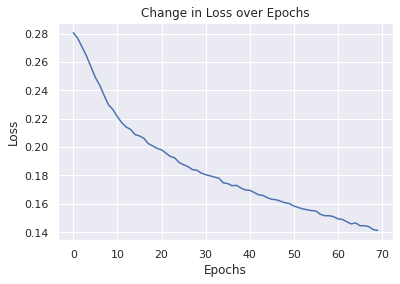

In [43]:
#Visualizing my data

plt.plot(epoch_nums,cum_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Change in Loss over Epochs')
plt.show()

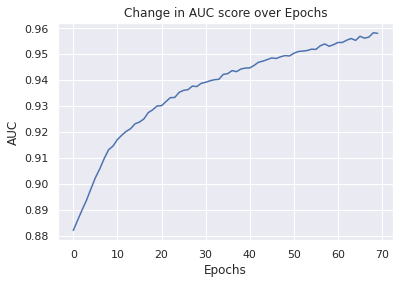

In [44]:
plt.plot(epoch_nums,cum_auc)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Change in AUC score over Epochs')
plt.show()